In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import torch
from torchvision.models import vit_b_32, ViT_B_32_Weights
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.io import decode_image
from torchvision.transforms import Resize
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('medium')

In [2]:
class GlobalStreetscapesSample(Dataset):
    def __init__(self, dataset):
        self.img_labels = dataset
        self.resize = Resize(size=(224, 224))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join("../", self.img_labels.iloc[idx].loc["path"])
        image = decode_image(img_path, apply_exif_orientation=True)
        label = int(self.img_labels.iloc[idx].loc["label"])
        image = self.resize(image)
        return image, label

In [3]:
samples = pd.read_csv('../../data/imgs/sampled.csv', index_col=0)
paths = pd.read_csv('../../data/img_paths.csv', index_col=0)
img_labels = samples.join(paths, on='uuid', how='inner')

print("samples rows:",samples.shape[0])
print("paths rows:",paths.shape[0])
print("img_labels rows:",img_labels.shape[0])

train_ratio = 0.8
train_val_df, test_df = train_test_split(img_labels, train_size=train_ratio, random_state=42, stratify=img_labels['label'])

# Then, split the remaining 85% into Train (70% total) and Val (15% total)
# 0.15 / 0.85 = ~0.1765
val_size = 0.15 / 0.85
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_size,
    stratify=train_val_df['label'],
    random_state=42
)

print(f"Train set: {len(train_df)} images")
print(f"Val set:   {len(val_df)} images")
print(f"Test set:  {len(test_df)} images")

display(train_df.head())

training_data = GlobalStreetscapesSample(
    train_df
)

validation_data = GlobalStreetscapesSample(
    val_df
)

test_data = GlobalStreetscapesSample(
    test_df
)

# Use num_workers for parallel data loading and pin_memory for faster GPU transfer
train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(validation_data, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

samples rows: 190693
paths rows: 200660
img_labels rows: 190693
Train set: 125632 images
Val set:   26922 images
Test set:  38139 images


,uuid,source,orig_id,city,country,iso3,s2_cell_id,label,lat,lon,path
64594,7383aec1-c4a6-471c-96fe-efa6c7e04546,Mapillary,997221287684574,Washington,United States,USA,9923602119078707200,18,38.902546,-77.019003,../data/imgs/9e691fc1-34a4-4660-9a2d-4e91ee242...
6195,353ee0ed-a759-42fe-93cd-ae9685aa08a7,Mapillary,520751399097435,Washington,United States,USA,9923602116931223552,30,38.899853,-77.016818,../data/imgs/ba26ad4e-8895-42ea-a3c7-de3bee6af...
156109,a4c7a21f-9528-4487-bc5e-632b5bc71009,Mapillary,1060123134699401,Washington,United States,USA,9923602531127132160,112,38.905668,-77.027231,../data/imgs/bac611f9-29f8-4c8f-801a-4541e77ad...
53464,0379dc28-432d-4e79-822e-75c57d2964e6,Mapillary,3510668989257064,Washington,United States,USA,9923602148875042816,72,38.901423,-77.025952,../data/imgs/89ad058b-a4a4-41f0-b0c7-7d8752278...
164770,c3c08093-e77d-4b3f-a869-56e098db17b1,Mapillary,185596580520841,Washington,United States,USA,9923602213567987712,102,38.893265,-77.033675,../data/imgs/a28511b3-59c9-4dbb-bf69-6b423eb2f...


Washington


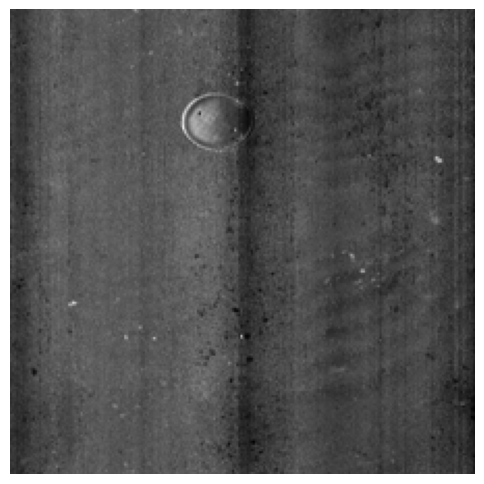

In [4]:
p = os.path.join("../", training_data.img_labels.iloc[10].loc["path"])
print(training_data.img_labels.iloc[10].loc["city"])
img = Image.open(p).convert("RGB")
img = img.resize((224, 224))
plt.figure(figsize=(6,10))
plt.imshow(img)
plt.axis("off")
plt.show()

In [5]:
# Base Vision Transformer Docs: https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py
# VIT_B_16 Docs: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html
weights = ViT_B_32_Weights.IMAGENET1K_V1
transform = weights.transforms()

model = vit_b_32(weights=weights)

in_features = model.heads.head.in_features
num_classes = img_labels.label.nunique()

# Replace the default number of classes
print(f"Previous head: {model.heads.head}")
model.heads.head = torch.nn.Linear(in_features=in_features, out_features=num_classes)
model.num_classes = num_classes
print(f"Previous head: {model.heads.head}")
print(f"Number of classes: {model.num_classes}")

model = model.to(device=device)
model = torch.compile(model)
print(f"Using device: {device}")

Previous head: Linear(in_features=768, out_features=1000, bias=True)
Previous head: Linear(in_features=768, out_features=144, bias=True)
Number of classes: 144
Using device: cuda


In [6]:
num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Changed to OneCycleLR with 10% warmup
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,
    steps_per_epoch=len(train_dataloader),
    epochs=num_epochs,
    pct_start=0.1  # 10% of total steps used for warmup
)

# Initialize GradScaler for Automatic Mixed Precision (AMP)
scaler = torch.amp.GradScaler('cuda')

train_loss_list = []
val_loss_list = []
train_loss = 0
for epoch in range(num_epochs):
    print(f"EPOCH: {epoch+1}")

    current_loss = 0
    model.train()
    for inputs, labels in tqdm(train_dataloader,  desc="Training"):
        # Move to GPU with non_blocking for better performance
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        inputs = transform(inputs)

        optimizer.zero_grad()

        # Runs the forward pass with autocasting (FP16)
        with torch.amp.autocast('cuda'):
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)

        # Scales loss. Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()

        scheduler.step()

        current_loss += loss.item()

    avg_train_loss = current_loss / len(train_dataloader)
    train_loss_list.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        # Use val_dataloader here instead of test_dataloader
        for inputs, labels in tqdm(val_dataloader, desc="Validation", leave=False):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            inputs = transform(inputs)

            # AMP for validation as well
            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_dataloader)
    val_loss_list.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.3f} | Val Loss: {avg_val_loss:.3f}")
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")

    torch.save(model.state_dict(), f'vit_b_32_base_epoch{epoch}.pth')


EPOCH: 1


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 4.119 | Val Loss: 3.170
LR: 0.000052
EPOCH: 2


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 2.612 | Val Loss: 2.374
LR: 0.000100
EPOCH: 3


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 2.012 | Val Loss: 2.038
LR: 0.000099
EPOCH: 4


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 1.665 | Val Loss: 1.937
LR: 0.000097
EPOCH: 5


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 1.430 | Val Loss: 1.860
LR: 0.000093
EPOCH: 6


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 1.256 | Val Loss: 1.775
LR: 0.000088
EPOCH: 7


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 1.116 | Val Loss: 1.813
LR: 0.000082
EPOCH: 8


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 1.011 | Val Loss: 1.774
LR: 0.000075
EPOCH: 9


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 0.938 | Val Loss: 1.775
LR: 0.000067
EPOCH: 10


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 0.898 | Val Loss: 1.760
LR: 0.000059
EPOCH: 11


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 0.869 | Val Loss: 1.730
LR: 0.000050
EPOCH: 12


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 0.854 | Val Loss: 1.737
LR: 0.000041
EPOCH: 13


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 0.839 | Val Loss: 1.713
LR: 0.000033
EPOCH: 14


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 0.829 | Val Loss: 1.711
LR: 0.000025
EPOCH: 15


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 0.827 | Val Loss: 1.659
LR: 0.000018
EPOCH: 16


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 0.822 | Val Loss: 1.654
LR: 0.000012
EPOCH: 17


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 0.821 | Val Loss: 1.654
LR: 0.000007
EPOCH: 18


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 0.820 | Val Loss: 1.657
LR: 0.000003
EPOCH: 19


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 0.819 | Val Loss: 1.660
LR: 0.000001
EPOCH: 20


Training:   0%|          | 0/982 [00:00<?, ?it/s]

Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Train Loss: 0.819 | Val Loss: 1.661
LR: 0.000000


In [7]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        inputs = transform(inputs)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader)
accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.3f}")
print(f"Test Accuracy: {accuracy:.2f}%")

  0%|          | 0/298 [00:00<?, ?it/s]

Test Loss: 1.676
Test Accuracy: 77.68%


In [8]:
print(train_loss_list)
print(val_loss_list)

[4.118983264853172, 2.61201296828672, 2.0118153565041643, 1.6652493887180708, 1.4296115838340246, 1.2560622077852548, 1.115618362506878, 1.0105725802981926, 0.9375126948788792, 0.8978661619839988, 0.8693026845056996, 0.8542240938805271, 0.8391244151684515, 0.8290157730249184, 0.8266938573959646, 0.8222795770998642, 0.8206964611035986, 0.8198087856385956, 0.8193676024371883, 0.8192291938360257]
[3.1701265048076754, 2.3739494136159456, 2.03827600061046, 1.937184801033888, 1.8602622199397516, 1.7746642782789837, 1.8132756360899216, 1.7741193308084497, 1.7753116191845935, 1.7600032927300693, 1.7304434296079156, 1.7370510412053475, 1.7125065925561986, 1.710995167352577, 1.659414460308744, 1.6542658811496898, 1.6541859278746691, 1.657284992001068, 1.6600288039700115, 1.6612143968518875]


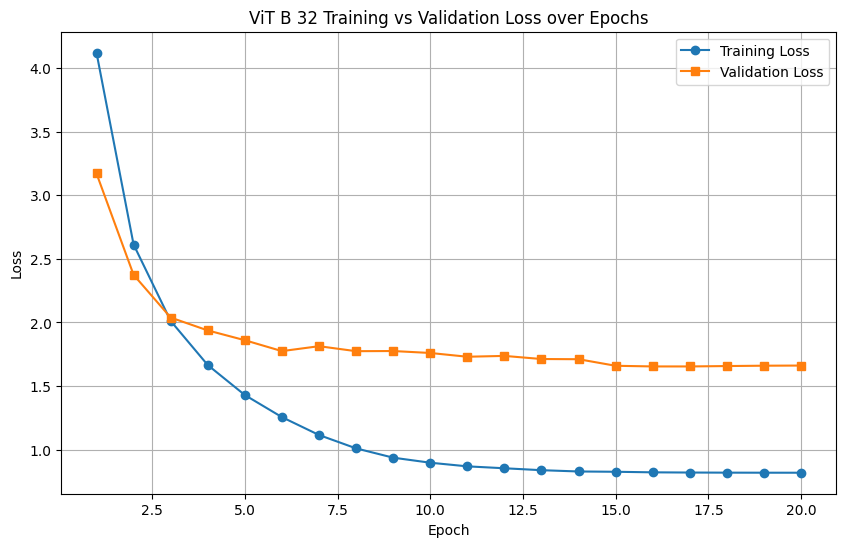

In [9]:
# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_list, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_list, marker='s', label='Validation Loss')
plt.title('ViT B 32 Training vs Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()